# Representation Analysis

In [1]:
import sys

# check whether it runs in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install timm==0.5.4
    !pip3 install matplotlib==3.7.1
    !pip3 install scikit-learn==1.2.2
    !pip3 install fastai==2.7.12
    !pip3 install einops==0.6.0
    !pip3 install gdown==4.7.1
    !pip3 install yacs==0.1.8    
    !git clone https://github.com/naver-ai/cl-vs-mim.git
    root = "./cl-vs-mim"
    sys.path.append(root)

In [2]:
import torch

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else None

/home/parkn4/scratch/conda/envs/cl_vs_mim/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 1.13.1+cu117 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x14f340b36af0> 
Device name: NVIDIA A100-SXM4-40GB


In [28]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs
from utils import subsample

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=16,
)

## Load the Models

In [18]:
# MoCo
import torch
import models.moco as moco
from models.moco import load_state_dict
from utils import download

name = "moco_vit_b" 
path = "checkpoints/moco_vit_b.pt"
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

In [ ]:
# SimMIM 
import gdown
import torch
import models.simmim as simmim
from models.simmim import load_state_dict

name = "simmim_vit_b"
path = "checkpoints/simmim_vit_b.pt"
url = "https://drive.google.com/u/1/uc?id=1dJn6GYkwMIcoP3zqOEyW1_iQfpBi8UOw"

gdown.cached_download(url, path, quiet=False)  # download checkpoints

model = simmim.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model

## Fourier Analysis

In [ ]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents
    

model = model_moco  # select a model
fourier_latents = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        _, zs, _, _ = model(xs)
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents = torch.stack(get_fourier_latents(latents))
    fourier_latents.update(_fourier_latents)

    if i > -1:
        break
        
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
fourier_latents = fourier_latents.avg
ax.plot(range(13), fourier_latents[:,-1][::2], marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
ax.set_ylim(top=-1.5, bottom=-3.5)
plt.show()

## Toekn-level t-SNE Visualization

/tmp/ipykernel_1253677/3108845429.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")):


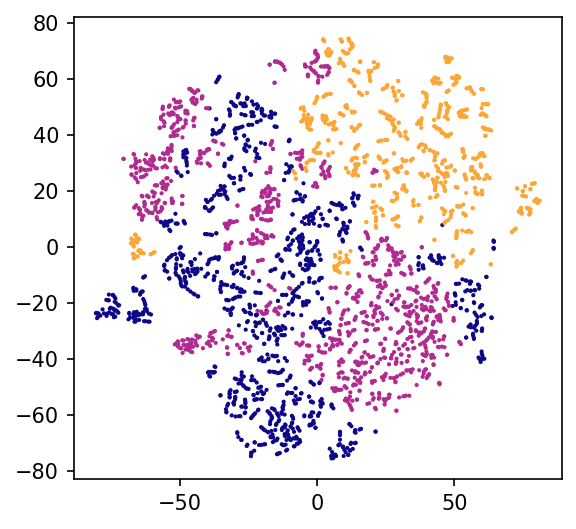

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()

    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * 196 for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=1)
    
    
model = model_moco  # select a model
xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    _, zs, _, _ = model(xs)
    zs = zs[:-1]

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
visualize_token_tsne(ax, zs, depth=10, ys=ys)  # coloring at the image level